This notebook pertains to the Kaggle [Natural Question and Answer competition](https://www.kaggle.com/c/tensorflow2-question-answering/overview). I'm late to the competition (there are 6 days left in a 3 month compeition). But the competition was interesting. I ended up ranking 152/1240 = 12%. I spent my time trying to:
1. Understand the data and the problem, since I am particularly interested in NLP problems this competition attracted me and I know that by understanding the problem and the data I can be better prepared for future NLP problems
2. Apply the Google baseline model as well as possible (Google published a model that had results that would have been good enough to rank in around the top 10% so I knew this would be a reasonable path to good results in 6 days)

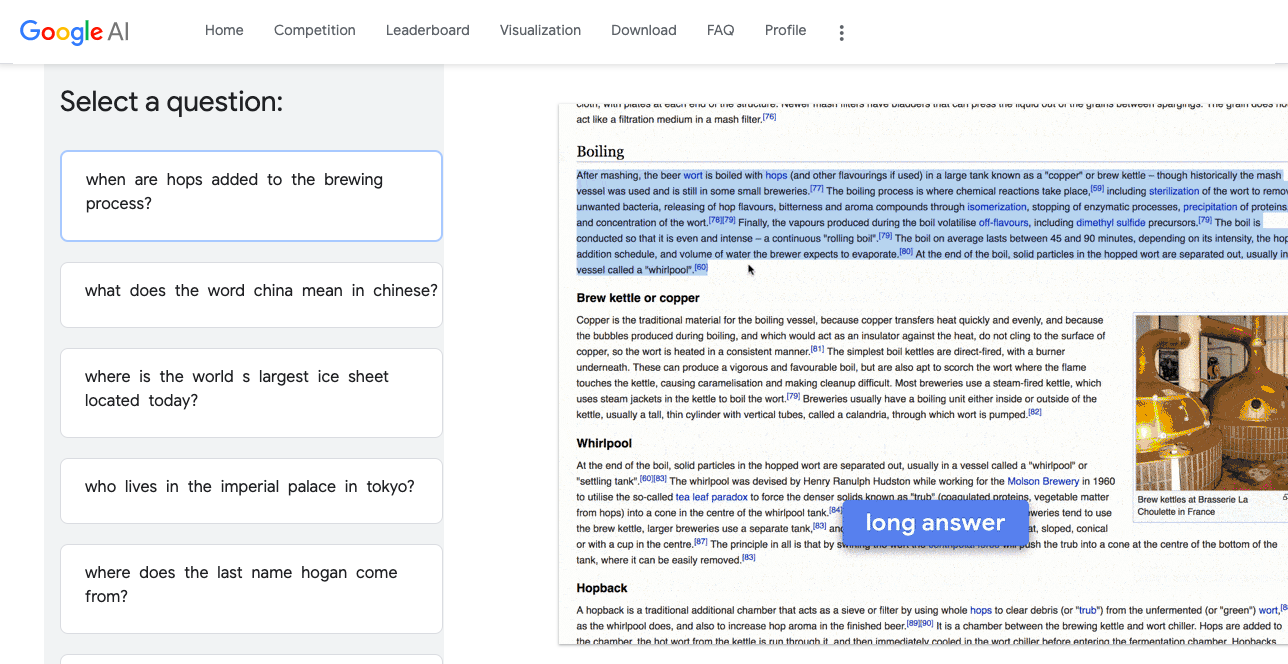
source: https://ai.google.com/research/NaturalQuestions/visualization

The purpose of the competition is to train a model that can take in a Wikipedia article, a natural (human generated) question about that article, and potential answers; from those inputs we want the model to pick the right answer. Each instance of the training data has an article, a question, and an answer. Some questions require longer answers, shorter answers, and there are some Yes/No questions. For the longer and shorter answers the answers are all sections of text taken from the article.

### Scoring
The competition is judged on micro F1 score, which is a form of the [F1 score](https://en.wikipedia.org/wiki/F1_score). The F1 score is a way of measuring both how many of correct answers a model is able to predict (recall), as well as how often is makes incorrect predictions (precision). 

### Challenges
There are multiple challenges within this competiion:
1. The amount of data for training and testing is reasonably large, we can also expect that deep learning models will perform best on this task (since deep learning models have been producing state of the art scores on NLP tasks recently). Thus, computing resources will be a concern (memory for the datasize, and computing speed for training deep learning models which require extensive numerical computations).
2. This is a new problem. So, it's likely we will need to use new technology. As mentioned Deep Learning is where the best results are likely to come from, one model which is suggested by the competion itself is called [Bidirectional Encoder Representations from Transformers (BERT)](https://arxiv.org/abs/1810.04805). I suspect that good results might come from using BERT and tuning it to suit this problem.
3. There are a variety of types of questions, so the model needs to not only know how to answer questions but also understand what kind of question it is answering. 

### Table of Contents
0. Import Libraries
1. Data Exploration
2. Data Engineering
3. Testing Harness 
4. Baseline Model
5. Improvements
6. Final Submission and Analysis

## 0. Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

import tensorflow as tf
import tensorflow.keras as tk

import os
import sys
import json
import collections

import tqdm
import absl

In [2]:
on_kaggle = os.path.exists('/kaggle')
print('On kaggle?:', on_kaggle)

root='../tf-question-answering/'
output_dir='../tf-question-answering/'
if on_kaggle:
    root = '../input/'
    output_dir = '../working/'
joint_dir = os.path.join(root, 'bert-joint-baseline')
qa_dir = os.path.join(root, 'tensorflow2-question-answering')
nq_dir = os.path.join(root, 'nqdir')

sys.path.append(joint_dir)
sys.path.append(nq_dir)

On kaggle?: False


In [3]:
import modeling
import tokenization
import bert_utils
from nq_dataset_utils import *
import nq_eval

In [4]:
# these flags define how the model runs and how the data is structured
# some of the flags are not pertinent to this notebook since we are not training the model
# but some are for example: use TPU
# these are more or less the default values for this pretrained model

# load and delete flags so that I can set new ones
# use absl for TF 2.0 compatibility
from nq_flags import DEFAULT_FLAGS as FLAGS
from nq_flags import del_all_flags
flags = absl.flags
del_all_flags(flags.FLAGS)
# ----------------------------------------------------------------------------------------
# Settings for which parts of the notebook to run
flags.DEFINE_bool("run_analysis", True, "Whether to run analysis parts of notebook.")
flags.DEFINE_bool("run_train", False, "Whether to run training parts of notebook.")
flags.DEFINE_bool("run_valid", True, "Whether to run validation parts of notebook.")
flags.DEFINE_bool("smaller_valid_dataset", False, "Whether to use the smaller validation dataset")
flags.DEFINE_bool("validation_from_scratch", False, "Whether to use the smaller validation dataset")
flags.DEFINE_bool("run_test", True, "Whether to run the test/submission parts of notebook.")
# TPU or No (only use if training large BERT Models)
flags.DEFINE_bool("use_tpu", False, "If to use cyclic learning rate.")
# ----------------------------------------------------------------------------------------
# Model and data parameters
flags.DEFINE_bool("do_lower_case", True, 'lower_case (uncased) model or no')
flags.DEFINE_string("vocab_file", os.path.join(joint_dir, "vocab-nq.txt"), 'path for vocab that was used for training')
flags.DEFINE_integer("max_seq_length_for_training", 512, 'seq len for training')
flags.DEFINE_integer("max_seq_length", 512, 'seq len')
flags.DEFINE_integer("doc_stride", 128, 'the sequences are created from document by moving the sequences by this amount')
flags.DEFINE_float("include_unknowns_for_training", 0.02, 'helps with regularization')
flags.DEFINE_float("include_unknowns", -1.0, 'whether to apply this regularization during prediction')
flags.DEFINE_boolean("skip_nested_contexts", True, 'the long answers are nested sometimes, this tells us whether we use the innermost only or also use the outer one')
flags.DEFINE_integer("max_contexts", 48, '')
flags.DEFINE_integer("max_position", 50, '')
flags.DEFINE_integer("max_query_length", 64, '')
# ----------------------------------------------------------------------------------------
# Training and prediction Parameters
flags.DEFINE_integer("epochs", 1, "Total epochs for training.")
flags.DEFINE_integer("train_batch_size", 5, "Batch size for training.")
flags.DEFINE_integer("shuffle_buffer_size", 10000, "Shuffle buffer size for training.")
flags.DEFINE_integer("batch_accumulation_size", 100, "Number of batches to accumulate gradient before applying optimization.")
flags.DEFINE_float("init_learning_rate", 3e-5, "The initial learning rate for AdamW optimizer.")
flags.DEFINE_bool("cyclic_learning_rate", True, "If to use cyclic learning rate.")
flags.DEFINE_float("init_weight_decay_rate", 0.01, "The initial weight decay rate for AdamW optimizer.")
flags.DEFINE_integer("num_warmup_steps", 1000, "Number of training steps to perform linear learning rate warmup.")
flags.DEFINE_integer("num_train_examples", None, "Number of precomputed training steps in 1 epoch.")
flags.DEFINE_integer("predict_batch_size", 25, "Batch size for predictions.")
flags.DEFINE_integer("max_eval_steps", 100, '')
flags.DEFINE_integer("eval_batch_size", 8, '')
flags.DEFINE_integer("max_predictions_per_seq", 20, '')
flags.DEFINE_float("warmup_proportion", .1, '')

# ----------------------------------------------------------------------------------------
flags.DEFINE_integer("n_best_size", 5, 'this is used for post_processing')
flags.DEFINE_integer("max_answer_length", 30, '')

# ----------------------------------------------------------------------------------------
## Special flags - do not change
flags.DEFINE_boolean("logtostderr", True, "Logs to stderr")
flags.DEFINE_boolean("undefok", True, "it's okay to be undefined")
flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_string('HistoryManager.hist_file', '', 'kernel')

# Mark the flags as parsed so they can be used
FLAGS.mark_as_parsed()

In [5]:
# Flags for locations of files
# which ones get set may be dependent on the setting flags above 
# ----------------------------------------------------------------------------------------
# Model files
# If you want to use other Hugging Face's models, change this to `MY_OWN_NQ_DIR` and put the downloaded models at the right place.
#flags.DEFINE_string("model_dir", nq_dir, "Root dir of all Hugging Face's models")

#flags.DEFINE_string("model_name", "distilbert-base-uncased-distilled-squad", "Name of Hugging Face's model to use.")
# flags.DEFINE_string("model_name", "bert-base-uncased", "Name of Hugging Face's model to use.")
# flags.DEFINE_string("model_name", "bert-large-uncased-whole-word-masking-finetuned-squad", "Name of Hugging Face's model to use.")
flags.DEFINE_string("input_checkpoint_dir", os.path.join(nq_dir, "checkpoints"), 'where to load initial checkpoints from')
flags.DEFINE_string("output_checkpoint_dir", "checkpoints", 'where to store checkpoints')

# ----------------------------------------------------------------------------------------
# Data files (input and ouput)
# for the test/submission file
flags.DEFINE_string("test_file", os.path.join(qa_dir,"simplified-nq-test.jsonl"), 'test file location')
flags.DEFINE_string("test_tf_record", "nq_test.tfrecord", 'where the file is stored when the data is transformed into tensorflow objects')
flags.DEFINE_string("test_prediction_output_file", "predictions.json", 'where a prediction file is written')

# for the smaller validation file
if FLAGS.smaller_valid_dataset:
    flags.DEFINE_string("validation_file", os.path.join(nq_dir, "simplified-nq-dev-small.jsonl"), 'location of smaller file being read for validation')
    flags.DEFINE_string("validation_tf_record", "nq_valid_small.tfrecord", 'where the file is stored when the data is transformed into tensorflow objects')
    flags.DEFINE_string("validation_tf_record_with_labels", "nq_valid_small_with_labels.tfrecord", 'where the file is stored when the data is transformed into tensorflow objects')
    flags.DEFINE_string("validation_prediction_output_file", "validation_small_predictions.json", 'where a prediction file is written')
# for the larger validation file
else:
    flags.DEFINE_string("validation_file", os.path.join(nq_dir, "simplified-nq-dev.jsonl"), 'location of file being read for validation')
    flags.DEFINE_string("validation_tf_record", "nq_valid.tfrecord", 'where the file is stored when the data is transformed into tensorflow objects')
    flags.DEFINE_string("validation_tf_record_with_labels", "nq_valid_with_labels.tfrecord", 'where the file is stored when the data is transformed into tensorflow objects')
    flags.DEFINE_string("validation_prediction_output_file", "validation_predictions.json", 'where a prediction file is written')

# for the training files
#if FLAGS.run_train:
#    if os.path.isfile(os.path.join(nq_dir, "nq_train.tfrecord")):
#        train_tf_record = os.path.join(nq_dir, "nq_train.tfrecord")
#    elif os.path.isfile(os.path.join(nq_dir, "nq-train.tfrecords-00000-of-00001")):
#        train_tf_record = os.path.join(nq_dir, "nq-train.tfrecords-00000-of-00001")
#    else:
#        train_tf_record = os.path.join(joint_dir, "nq-train.tfrecords-00000-of-00001")

# Mark the flags as parsed so they can be used
FLAGS.mark_as_parsed()

In [6]:
is_submitting = False

if is_submitting:
    FLAGS.run_analysis=False
    FLAGS.run_train = False
    FLAGS.run_valid= False
    FLAGS.use_tpu = False
    FLAGS.run_test = True
    
print(f'Is submitting: {is_submitting}')

Is submitting: False


In [7]:
Span = collections.namedtuple("Span", ["start_token_idx", "end_token_idx", "score"])

## 1. Data Exploration

As mentioned above the dataset is reasonably large (~17GBB). I'll be doing data exploration on a subset of the data. We can't draw many statistical conclusions this way but we should be able to get a sense of the data structure. 

In [8]:
# The data is stored in a JSON file. 
# We'll read 10000 rows of the training data into a dataframe.
train_path = os.path.join(qa_dir, 'simplified-nq-train.jsonl')

# From ragnar123's kaggle notebook
def read_data(path, sample = True, chunksize = 10000):
    if sample == True:
        df = []
        with open(path, 'rt') as reader:
            for i in range(chunksize):
                df.append(json.loads(reader.readline()))
        df = pd.DataFrame(df)
        print('Our sampled dataset has {} rows and {} columns'.format(df.shape[0], df.shape[1]))
    else:
        df = []
        with open(path, 'rt') as reader:
            for line in reader:
                df.append(json.loads(line))
        df = pd.DataFrame(df)
        print('Our dataset has {} rows and {} columns'.format(df.shape[0], df.shape[1]))
    return df

if FLAGS.run_analysis:
    exp_data = read_data(train_path, sample = True)
    print(exp_data.head())

Our sampled dataset has 10000 rows and 6 columns
                                         annotations  \
0  [{'yes_no_answer': 'NONE', 'long_answer': {'st...   
1  [{'yes_no_answer': 'NONE', 'long_answer': {'st...   
2  [{'yes_no_answer': 'NONE', 'long_answer': {'st...   
3  [{'yes_no_answer': 'NONE', 'long_answer': {'st...   
4  [{'yes_no_answer': 'NONE', 'long_answer': {'st...   

                                       document_text  \
0  Email marketing - Wikipedia <H1> Email marketi...   
1  The Mother ( How I Met Your Mother ) - wikiped...   
2  Human fertilization - wikipedia <H1> Human fer...   
3  List of National Football League career quarte...   
4  Roanoke Colony - wikipedia <H1> Roanoke Colony...   

                                        document_url           example_id  \
0  https://en.wikipedia.org//w/index.php?title=Em...  5655493461695504401   
1  https://en.wikipedia.org//w/index.php?title=Th...  5328212470870865242   
2  https://en.wikipedia.org//w/index.php?title

In [9]:
# Can't read the rows well, let's look at one in depth
# Two of the rows are only for reference so we only look at 4 rows
def print_sample_text(index):
    print(f'Sample text for index {index}:')
    print()
    print('document_text:', exp_data.iloc[index]['document_text'][:500]+'...')
    print()
    print('question_text:', exp_data.iloc[index]['question_text'])
    print()
    print('long_answer_candidates:', exp_data.iloc[index]['long_answer_candidates'][:5]+['...'])
    print()
    print('annotations:', exp_data.iloc[index]['annotations'])

if FLAGS.run_analysis:
    print_sample_text(0)

Sample text for index 0:

document_text: Email marketing - Wikipedia <H1> Email marketing </H1> Jump to : navigation , search <Table> <Tr> <Td> </Td> <Td> ( hide ) This article has multiple issues . Please help improve it or discuss these issues on the talk page . ( Learn how and when to remove these template messages ) <Table> <Tr> <Td> </Td> <Td> This article needs additional citations for verification . Please help improve this article by adding citations to reliable sources . Unsourced material may be challenged and removed . ( Sep...

question_text: which is the most common use of opt-in e-mail marketing

long_answer_candidates: [{'start_token': 14, 'top_level': True, 'end_token': 170}, {'start_token': 15, 'top_level': False, 'end_token': 169}, {'start_token': 52, 'top_level': False, 'end_token': 103}, {'start_token': 53, 'top_level': False, 'end_token': 102}, {'start_token': 103, 'top_level': False, 'end_token': 156}, '...']

annotations: [{'yes_no_answer': 'NONE', 'long_answer':

The document_text field is a long string with the text of the article. It has some HTML tagging but according to the Kaggle description, most of it has been removed. The Kaggle competition instruction tells us this text is to be tokenized by whitespace. We notice that the punctionation like periods has white space added in front of it. 

The question_text is a string of text.

The long_answer_candidates is a list, inside the list are each of the candidate (potential) answers. Each candidate cooresponds to a section of the article text. The candidate is specified by a starting token and an ending token.

The annotations has some interesting information. It is a list with a dictionary in it. The dictionary tells us if the answer is a yes/no answer. It tells us the correct long answer. It also contains a short answer. Thus questions can contain both long and short answers. 

In [10]:
if FLAGS.run_analysis:
    # Checking to see if all of the annotations fields only have one item
    print('Annotations have one item:', all(len(i)==1 for i in exp_data['annotations']))
    # Checking to see if all the dictionaries have 4 items 
    print('Each annotation dictionary has four items:', 
          all(len(i[0])==4 for i in exp_data['annotations']))

Annotations have one item: True
Each annotation dictionary has four items: True


### Yes/No answers
Let's see what we can learn about the questions with Yes/No answers: what the questions look like, what the other fields look like.

In [11]:
if FLAGS.run_analysis:
    # Possible values
    possible_values = set()
    for i in exp_data['annotations']:
        possible_values.add(i[0]['yes_no_answer'])
    print('Possible values for the yes_no_answer field:', possible_values)

Possible values for the yes_no_answer field: {'NO', 'NONE', 'YES'}


In [12]:
# When yes_no_answer is None or Not None what do the short and long answers look like
if FLAGS.run_analysis:
    possible_types = {
        'Not NONE, short' : set(),
        'Not NONE, long' : set(),
        'NONE, short' : set(),
        'NONE, long' : set()
    }
    for i in exp_data['annotations']:
        if i[0]['yes_no_answer'] != 'NONE':
            possible_types['Not NONE, short'].add(type(i[0]['short_answers']))
            possible_types['Not NONE, long'].add(type(i[0]['long_answer']))
        if i[0]['yes_no_answer'] == 'NONE':
            possible_types['NONE, short'].add(type(i[0]['short_answers']))
            possible_types['NONE, long'].add(type(i[0]['long_answer']))
    print('Possible types of long and short answers depending on yes_no_answer:', possible_types)

Possible types of long and short answers depending on yes_no_answer: {'Not NONE, short': {<class 'list'>}, 'Not NONE, long': {<class 'dict'>}, 'NONE, short': {<class 'list'>}, 'NONE, long': {<class 'dict'>}}


The short answers is always a list, the long answer is always a dictionary. Let's see the lengths of these.

In [13]:
if FLAGS.run_analysis:
    possible_lens = {
        'Not NONE, short' : set(),
        'Not NONE, long' : set(),
        'NONE, short' : set(),
        'NONE, long' : set()
    }
    for i in exp_data['annotations']:
        if i[0]['yes_no_answer'] != 'NONE':
            possible_lens['Not NONE, short'].add(len(i[0]['short_answers']))
            possible_lens['Not NONE, long'].add(len(i[0]['long_answer']))
        if i[0]['yes_no_answer'] == 'NONE':
            possible_lens['NONE, short'].add(len(i[0]['short_answers']))
            possible_lens['NONE, long'].add(len(i[0]['long_answer']))
    print('Possible lengths of long and short answers depending on yes_no_answer:', possible_lens)

Possible lengths of long and short answers depending on yes_no_answer: {'Not NONE, short': {0}, 'Not NONE, long': {3}, 'NONE, short': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 21}, 'NONE, long': {3}}


The short answers are always empty lists when the yes_no_answer is not NONE. The long answer is always 3 items. I'm assuming that all of the long answers look the same when yes_no_answer has an answer.

In [14]:
if FLAGS.run_analysis:
    possible_dictionaries = list()
    for i in exp_data['annotations']:
        if i[0]['yes_no_answer'] != 'NONE':
            possible_dictionaries.append(i[0]['long_answer'])
    print('All dictionary values are the same when yes_no_answer is not None:',
          all(i==possible_dictionaries[0] for i in possible_dictionaries))

All dictionary values are the same when yes_no_answer is not None: False


Huh, now we need to find out what the dictionaries look like. Let's see the first five.

In [15]:
# First five dictionaries when yes_no_answer is not NONE
if FLAGS.run_analysis:
    possible_dictionaries[:5]

OK so even when there is a yes_no_answer there is still a long answer. Let's look at a couple YES answers, NO answers and NONE answers.

In [16]:
# let's get a few of the yes answer examples
if FLAGS.run_analysis:
    yes_mask = list()
    for i in exp_data['annotations']:
        if i[0]['yes_no_answer'] == 'YES':
            yes_mask.append(True)
        else:
            yes_mask.append(False)
    exp_data['annotations'][yes_mask].head()

In [17]:
# printing the first example from the yes answer examples
if FLAGS.run_analysis:
    print_sample_text(113)

Sample text for index 113:

document_text: Micrometer - wikipedia <H1> Micrometer </H1> Jump to : navigation , search This article is about the measuring device . For the unit of length , see Micrometre . Modern micrometer with a reading of 1.639 mm ± 0.005 mm . Assuming no zero error , this is also the measurement . Outside , inside , and depth micrometers <P> A micrometer ( / maɪˈkrɒmɪtər / my - KROM - i - tər ) , sometimes known as a micrometer screw gauge , is a device incorporating a calibrated screw widely used for precise measurem...

question_text: is the micrometer screw gauge used for measurement of inner diameter of tube

long_answer_candidates: [{'start_token': 59, 'top_level': True, 'end_token': 257}, {'start_token': 257, 'top_level': True, 'end_token': 297}, {'start_token': 297, 'top_level': True, 'end_token': 317}, {'start_token': 460, 'top_level': True, 'end_token': 590}, {'start_token': 590, 'top_level': True, 'end_token': 634}, '...']

annotations: [{'yes_no_answer': 

In [18]:
# let's get a few of the no answer examples
if FLAGS.run_analysis:
    no_mask = list()
    for i in exp_data['annotations']:
        if i[0]['yes_no_answer'] == 'NO':
            no_mask.append(True)
        else:
            no_mask.append(False)
    exp_data['annotations'][no_mask].head()

In [19]:
# printing the first example from the no answer examples
if FLAGS.run_analysis:
    print_sample_text(61)

Sample text for index 61:

document_text: Commonwealth of Nations - wikipedia <H1> Commonwealth of Nations </H1> Jump to : navigation , search `` The Commonwealth '' redirects here . It is not to be confused with the Commonwealth of Independent States . For other uses , see Commonwealth ( disambiguation ) . <Table> <Tr> <Th_colspan="2"> Commonwealth of Nations </Th> </Tr> <Tr> <Td_colspan="2"> Flag Logo </Td> </Tr> <Tr> <Td_colspan="2"> Member states of the Commonwealth </Td> </Tr> <Tr> <Th> Headquarters </Th> <Td> Marlborough House , L...

question_text: is hong kong a part of the commonwealth

long_answer_candidates: [{'start_token': 46, 'top_level': True, 'end_token': 487}, {'start_token': 47, 'top_level': False, 'end_token': 54}, {'start_token': 54, 'top_level': False, 'end_token': 60}, {'start_token': 60, 'top_level': False, 'end_token': 69}, {'start_token': 69, 'top_level': False, 'end_token': 85}, '...']

annotations: [{'yes_no_answer': 'NO', 'long_answer': {'start_token': 6539,

In [20]:
# let's get a few of the NONE answer examples
if FLAGS.run_analysis:
    none_mask = list()
    for i in exp_data['annotations']:
        if i[0]['yes_no_answer'] == 'NONE':
            none_mask.append(True)
        else:
            none_mask.append(False)
    exp_data['annotations'][none_mask].head()

In [21]:
# printing one of the NONE answer examples
if FLAGS.run_analysis:
    print_sample_text(4)

Sample text for index 4:

document_text: Roanoke Colony - wikipedia <H1> Roanoke Colony </H1> Jump to : navigation , search `` Lost Colony '' redirects here . For other uses , see Lost Colony ( disambiguation ) . <Table> <Tr> <Td> </Td> <Td> This article 's lead section does not adequately summarize key points of its contents . Please consider expanding the lead to provide an accessible overview of all important aspects of the article . Please discuss this issue on the article 's talk page . ( March 2018 ) </Td> </Tr> </Table> <Table> ...

question_text: what happened to the lost settlement of roanoke

long_answer_candidates: [{'start_token': 32, 'top_level': True, 'end_token': 88}, {'start_token': 33, 'top_level': False, 'end_token': 87}, {'start_token': 88, 'top_level': True, 'end_token': 249}, {'start_token': 89, 'top_level': False, 'end_token': 95}, {'start_token': 95, 'top_level': False, 'end_token': 102}, '...']

annotations: [{'yes_no_answer': 'NONE', 'long_answer': {'start_toke

Huh, this is an ill formed answer. What is the example_id for this?

In [22]:
if FLAGS.run_analysis:
    print('example_id for ill formed answer:', exp_data.iloc[4]['example_id'])

example_id for ill formed answer: 5489863933082811018


In [23]:
# printing another one of the NONE answer examples
if FLAGS.run_analysis:
    print_sample_text(3)

Sample text for index 3:

document_text: List of National Football League career quarterback wins leaders - wikipedia <H1> List of National Football League career quarterback wins leaders </H1> Jump to : navigation , search <Table> <Tr> <Th> NFL lists </Th> </Tr> <Tr> <Td> Current season ( show ) <Ul> <Li> 2017 season </Li> </Ul> </Td> </Tr> <Tr> <Td> Quarterbacks ( show ) <Ul> <Li> Starting quarterbacks by touchdowns / touchdowns ( playoffs ) / yardage / 5000 yard seasons / completion <Ul> <Li> by team BUF </Li> <Li> MIA </Li> <Li> NE...

question_text: who had the most wins in the nfl

long_answer_candidates: [{'start_token': 28, 'top_level': True, 'end_token': 469}, {'start_token': 29, 'top_level': False, 'end_token': 35}, {'start_token': 35, 'top_level': False, 'end_token': 50}, {'start_token': 42, 'top_level': False, 'end_token': 48}, {'start_token': 50, 'top_level': False, 'end_token': 213}, '...']

annotations: [{'yes_no_answer': 'NONE', 'long_answer': {'start_token': 509, 'cand

I've learned that the short answers are always empty when there is a yes_no_answer, when there is NONE for the yes_no_answer the short answer is still occassionally empty but otherwise has a range between 1 and 21 answers (that's a lot...). The long answer always has 3 items. But in poking around I found one candidate, with example id = 5489863933082811018, that had ill formed answers (the yes_no_answer was NONE, the long_answer had -1 for all three dictionary entries, the short_answer was empty).

### Long answer
I want to check if there are other instances of ill formed long answers.

In [24]:
if FLAGS.run_analysis:
    ill_formed_mask = [None]*len(exp_data)
    for i, row in exp_data.iterrows():
        long_values = list(row['annotations'][0]['long_answer'].values())
        if any(value<0 for value in long_values):
            ill_formed_mask[i] = True
        else:
            ill_formed_mask[i] = False
    exp_data[ill_formed_mask].head()

In [25]:
if FLAGS.run_analysis:
    print('How many ill formed entries?', np.sum(ill_formed_mask))

How many ill formed entries? 5000


Odd, half of the entries have what I call ill formed entries for their long_answer. Why do some of the questions have no answer? I guess they're not really ill formed but something else. However, example_id 5489863933082811018 had no answers, I want to know if this is typical.

In [26]:
if FLAGS.run_analysis:
    possible_yes_no = set()
    possible_short_len = set()
    for i, row in exp_data[ill_formed_mask].iterrows():
        possible_yes_no.add(row['annotations'][0]['yes_no_answer'])
        possible_short_len.add(len(row['annotations'][0]['short_answers']))
    print('Possible yes_no_answer values, when there is no long answer:', possible_yes_no)
    print('Possible short_answers lengths, when there is no long answer:', possible_short_len)

Possible yes_no_answer values, when there is no long answer: {'NONE'}
Possible short_answers lengths, when there is no long answer: {0}


Half of the 10000 rows of training data I've imported have no answers. The yes_no_answer field is 'NONE' the short_answers is empty, the long_answer has negative entries. I'm going to poke around Kaggle to see if there is an explanation.

Found the [Github Page about this Dataset](https://github.com/google-research-datasets/natural-questions) (release by Google). The fact of half empty scores is totally expected. The empty answers are what will define the precision score. The [README file](https://github.com/google-research-datasets/natural-questions/blob/master/README.md) about this dataset tells us that 152k of the total 307k examples have empty answers. When there is an empty long answer there is no short answer or Yes No answer. Of the 152k with long answers (i.e. any answer) 110k of those have either a short answer or a yes no answer. Of those that have either a short answer or a yes no answer 106k of those are short answers 3.8k are yes no answers. 90% of the short answers only have one answer. 

## 2. Data Engineering
As mentioned, BERT represents the leading technology for these natural question answering problems, for example BERT as of now holds the top scores for the [Stanford Question Answering Dataset (SQuAD)](https://rajpurkar.github.io/SQuAD-explorer/). There are a variety of different BERTs. BERTs utilize the encoder side (the side that reads the data) of an algorithm called a Transformer. A transfomer is formed from stacks of attention mechanisms used to encode (read) and decode (write) data. Attention mechanisms are a type of algorithm that acts on sequences of data (for example an ordered sequence of words i.e. writen language), it is special because it is able to draw connections inside that sequences (i.e connections between words in a sequence of words). In this way attention mechanisms are able to draw meaning from that sequence. 

In order to feed data to the BERT we need to break up our sequence of data into individual parts (i.e. tokenization), and we need to turn our words into a mathematical representation, which means we need to create a map of the possible words (a vocabulary) and represent the word within that vocabulary. 

Additionally, most deep learning algorithms that act on sequences (RNNs make up the bulk of them so in the literature sometimes we just talk about RNNs), namely RNNs of which an attention mechanism is a type of, work better when longer sequences are broken into shorter sequences (so instead of reading an entire article it might read a few hundred words of that article at a time). Marking the beginning and ends of theses sequences, as well as using the html to mark the type of the sequence (paragraph, table, etc.) is helpful.

Lastly, we want to think about what we want the model to do and thus how data will be fed into the model, how the model will output data, and based on how the model is outputing data we also will think about how to format the target data in a way that the model output can be compared and trained against that target data. The model ought to: take a sequence of data, take a question, take a sequence of potential places where the answer will be found in the article, and then it should tell us if: 1. it there is a short answer inside that long answer, 2. if there isn't a short answer but there is an answer in there. 3 (&4). if there is an answer inside the long answer possibility as well as a short yes/no answer to the question based on the answer possibility (and if the answer is yes or if the answer is no), 5. there is no answer.

Thankfully someone at google has [done this](https://arxiv.org/pdf/1901.08634.pdf) for the baseline google model. He also took into account the fact that most sequences of text in an article don't have potential answers, and most sequences that have potential answers only have wrong answers. But if we give the deep learning model a ton of sequences that have no info or have wrong answers we're mostly just teaching it to look for no info or wrong answers. It's more productive for it to get a balanced idea of what good answers look like too. So the processed data from the google baseline reduces the number of bad answers vs. good answers so that the mix is more balanced (downsampling).

We get all of this from the "simplified" jsons. Additionally we need to do a few steps:
* ingest the jsonl and output data that can be ingested by our model. In the case of the BERT joint model we need: unique ids, input ids, input masks, segment ids
* we need to produce a token map to use later for mapping predictions to examples

In [27]:
def jsonl_iterator(jsonl_files, to_json=False):
    for file_path in jsonl_files:
        print(file_path)
        with open(file_path, "r", encoding="UTF-8") as fp:
            for jsonl in fp:
                raw_example = jsonl
                if to_json:
                    raw_example = json.loads(jsonl)
                yield raw_example

In [28]:
def get_dataset(tf_record_file, seq_length, batch_size=1, shuffle_buffer_size=0, is_training=False):

    if is_training:
        features = {
            "unique_ids": tf.io.FixedLenFeature([], tf.int64),
            "input_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
            "input_mask": tf.io.FixedLenFeature([seq_length], tf.int64),
            "segment_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
            "start_positions": tf.io.FixedLenFeature([], tf.int64),
            "end_positions": tf.io.FixedLenFeature([], tf.int64),
            "answer_types": tf.io.FixedLenFeature([], tf.int64)
        }
    else:
        features = {
            "unique_ids": tf.io.FixedLenFeature([], tf.int64),
            "input_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
            "input_mask": tf.io.FixedLenFeature([seq_length], tf.int64),
            "segment_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
            "token_map": tf.io.FixedLenFeature([seq_length], tf.int64)
        }   
    # Taken from the TensorFlow models repository: https://github.com/tensorflow/models/blob/befbe0f9fe02d6bc1efb1c462689d069dae23af1/official/nlp/bert/input_pipeline.py#L24
    def _decode_record(record, features):
        """Decodes a record to a TensorFlow example."""
        example = tf.io.parse_single_example(record, features)

        # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
        # So cast all int64 to int32.
        for name in list(example.keys()):
            t = example[name]
            if name != 'unique_ids': #t.dtype == tf.int64:
                if t.dtype == tf.int64:
                    t = tf.cast(t, tf.int32)
                example[name] = t

        return example

    def _select_data_from_record(record):
        
        x = {
            'unique_ids': record['unique_ids'],
            'input_ids': record['input_ids'],
            'input_mask': record['input_mask'],
            'segment_ids': record['segment_ids']
        }
        
        if not is_training:
            x['token_map'] = record['token_map']

        if is_training:
            y = {
                'start_positions': record['start_positions'],
                'end_positions': record['end_positions'],
                'answer_types': record['answer_types']
            }

            return (x, y)
        
        return x
    
    def _decode_tokens(record):
        return tf.io.parse_single_example(record, 
                                          features={
                                              "unique_ids": tf.io.FixedLenFeature([], tf.int64),
                                              "token_map" :  tf.io.FixedLenFeature([seq_length], tf.int64)
                                              })

    raw_ds = tf.data.TFRecordDataset(tf_record_file)
    
    decoded_ds = raw_ds.map(lambda record: _decode_record(record, features))
    #decoded_ds = decoded_ds.map(_select_data_from_record)
    
    if shuffle_buffer_size > 0:
        decoded_ds = decoded_ds.shuffle(shuffle_buffer_size)
    
    dataset = decoded_ds.batch(batch_size=32,drop_remainder=False)
    token_map_ds = raw_ds.map(_decode_tokens)
    return dataset, token_map_ds

In [29]:
# Convert test examples to tf records.
if FLAGS.run_test:
    creator = TFExampleCreator(is_training=False)
    nq_lines = jsonl_iterator([FLAGS.test_file])
    creator.process_nq_lines(nq_lines=nq_lines, output_tfrecord=FLAGS.test_tf_record)
    test_ds, test_tmds = get_dataset(FLAGS.test_tf_record,
                         seq_length=FLAGS.max_seq_length,
                         batch_size=FLAGS.predict_batch_size,
                         is_training=False
                         )

-1.0
512
../tf-question-answering/tensorflow2-question-answering/simplified-nq-test.jsonl
Examples processed: 10
Instance processed: 306
--------------------------------------------------------------------------------
Examples processed: 20
Instance processed: 634
--------------------------------------------------------------------------------
Examples processed: 30
Instance processed: 902
--------------------------------------------------------------------------------
Examples processed: 40
Instance processed: 1110
--------------------------------------------------------------------------------
Examples processed: 50
Instance processed: 1327
--------------------------------------------------------------------------------
Examples processed: 60
Instance processed: 1568
--------------------------------------------------------------------------------
Examples processed: 70
Instance processed: 1715
--------------------------------------------------------------------------------
Examples p

In [30]:
if FLAGS.run_valid and FLAGS.validation_from_scratch:
    creator = TFExampleCreator(is_training=False)
    nq_lines = jsonl_iterator([FLAGS.validation_file])
    creator.process_nq_lines(nq_lines=nq_lines, output_tfrecord=FLAGS.validation_tf_record)  

if FLAGS.run_valid:
    if FLAGS.validation_from_scratch:
        valid_ds, valid_tmds = get_dataset(FLAGS.validation_tf_record,
                             seq_length=FLAGS.max_seq_length,
                             batch_size=FLAGS.predict_batch_size,
                             is_training=False
                             )
    else:
        valid_ds, valid_tmds = get_dataset(os.path.join(nq_dir, FLAGS.validation_tf_record),
                             seq_length=FLAGS.max_seq_length,
                             batch_size=FLAGS.predict_batch_size,
                             is_training=False
                             )

## 3. Testing Harness
We ought to have a testing harness that can take in a trained model (potentially pretrained) and run that model against a test set (either the small test set that has been chosen for the public leaderboard, which is given to us as 'simplified-nq-test.jsonl', or against a cross validation set that we set out ourselves.

The testing harness ought to output the F1 score. 

Google provides evaluation scripts that I can use (with some modifications)

## 4. Baseline Model
There is a [baseline model](https://github.com/google-research/language/tree/master/language/question_answering/bert_joint) provided by Google for this competition. It uses BERT to predict a short answer or no answer. Using the short answer it picks a long answer candidate (the short answer has to be contained in the long answer). This baseline has strong performance, and is a good place to start. Much of this comes from @mmmarchetti and @yihdarshieh on Kaggle. 

In [31]:
# the BERT models require a config file. These are values for the pretrained model.
joint_config = {'attention_probs_dropout_prob':0.1,
'hidden_act':'gelu', # 'gelu',
'hidden_dropout_prob':0.1,
'hidden_size':1024,
'initializer_range':0.02,
'intermediate_size':4096,
'max_position_embeddings':512,
'num_attention_heads':16,
'num_hidden_layers':24,
'type_vocab_size':2,
'vocab_size':30522}

In [32]:
# as mentioned the BERT model can be improved 
# it is improved by not only predicting the short answer
# this layer predicts the type of answer 
# i.e. whether it matches one of the five classes of:
# short answer + long answer, long answer only, long answer + yes, longer answer + no, no answer
class TDense(tf.keras.layers.Layer):
    def __init__(self,
                 output_size,
                 kernel_initializer=None,
                 bias_initializer="zeros",
                **kwargs):
        super().__init__(**kwargs)
        self.output_size = output_size
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
    def build(self,input_shape):
        dtype = tf.as_dtype(self.dtype or tf.keras.backend.floatx())
        if not (dtype.is_floating or dtype.is_complex):
          raise TypeError("Unable to build `TDense` layer with "
                          "non-floating point (and non-complex) "
                          "dtype %s" % (dtype,))
        input_shape = tf.TensorShape(input_shape)
        if tf.compat.dimension_value(input_shape[-1]) is None:
          raise ValueError("The last dimension of the inputs to "
                           "`TDense` should be defined. "
                           "Found `None`.")
        last_dim = tf.compat.dimension_value(input_shape[-1])
        self.input_spec = tf.keras.layers.InputSpec(min_ndim=3, axes={-1: last_dim})
        self.kernel = self.add_weight(
            "kernel",
            shape=[self.output_size,last_dim],
            initializer=self.kernel_initializer,
            dtype=self.dtype,
            trainable=True)
        self.bias = self.add_weight(
            "bias",
            shape=[self.output_size],
            initializer=self.bias_initializer,
            dtype=self.dtype,
            trainable=True)
        super(TDense, self).build(input_shape)
    def call(self,x):
        return tf.matmul(x,self.kernel,transpose_b=True)+self.bias

In [33]:
# this uses the configuration file above to make a BERT Model
# it uses the pretrained BERT model and it adds in the ability to predict the "class" of answer
def mk_joint(config):
    # need seq_len to define the model
    seq_len = config['max_position_embeddings']
    # these are the inputs, one of them unique_ids just get's passed through
    # the other inpus are what the BERT model expects
    unique_ids  = tf.keras.Input(shape=(1,),dtype=tf.int64,name='unique_ids')
    input_ids   = tf.keras.Input(shape=(seq_len,),dtype=tf.int32,name='input_ids')
    input_mask  = tf.keras.Input(shape=(seq_len,),dtype=tf.int32,name='input_mask')
    segment_ids = tf.keras.Input(shape=(seq_len,),dtype=tf.int32,name='segment_ids')
    # here the BERT model is added with the configurations from the pretrained set
    BERT = modeling.BertModel(config=config,name='bert')
    # these are the outputs of the BERT model
    pooled_output, sequence_output = BERT(input_word_ids=input_ids,
                                          input_mask=input_mask,
                                          input_type_ids=segment_ids)
    # we use the one of the outputs to predict the start and the end of the short answer
    logits = TDense(2,name='logits')(sequence_output)
    start_logits,end_logits = tf.split(logits,axis=-1,num_or_size_splits= 2,name='split')
    start_logits = tf.squeeze(start_logits,axis=-1,name='start_squeeze')
    end_logits   = tf.squeeze(end_logits,  axis=-1,name='end_squeeze')
    # we use the other output to predict the answer type or class
    ans_type      = TDense(5,name='ans_type')(pooled_output)
    # the model takes in 4 inputs and gives 4 outputs (one of those values simply passes through)
    return tf.keras.Model([unique_ids,input_ids,input_mask,segment_ids],
                          [unique_ids,start_logits,end_logits,ans_type],
                          name='bert-baseline')    

In [34]:
# build the BERT joint model and load the checkpoint from the pretrained version
joint= mk_joint(joint_config)
cpkt = tf.train.Checkpoint(model=joint)
cpkt.restore(os.path.join(joint_dir, 'model_cpkt-1')).assert_consumed()
joint.summary()
tk.utils.plot_model(joint)

Model: "bert-baseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (BertModel)                ((None, 1024), (None 335141888   input_ids[0][0]                  
                                                                 input_mask[0][0]     

### Post-Processing

In [35]:
class ScoreSummary(object):
  def __init__(self):
    self.predicted_label = None
    self.short_span_score = None
    self.cls_token_score = None
    self.answer_type_probs = None

In [36]:
class EvalExample(object):
  """Eval data available for a single example."""
  def __init__(self, example_id, candidates):
    self.example_id = example_id
    self.candidates = candidates
    self.results = {}
    self.features = {}

In [37]:
def get_best_indexes(logits, n_best_size):
  """Get the n-best logits from a list."""
  index_and_score = sorted(
      enumerate(logits[1:], 1), key=lambda x: x[1], reverse=True)
  best_indexes = []
  for i in range(len(index_and_score)):
    if i >= n_best_size:
      break
    best_indexes.append(index_and_score[i][0])
  return best_indexes

def top_k_indices(logits,n_best_size,token_map):
    indices = np.argsort(logits[1:])+1
    indices = indices[token_map[indices]!=-1]
    return indices[-n_best_size:]

In [38]:
def get_short_long_span(predictions, example):
    long_candidates_scored = list()
    for long_candidate in example.candidates:
        long_candidate_score = 0.
        if long_candidate['top_level']:
            for prediction in predictions:
                score, _, summary, start_span, end_span = prediction
                if score > 0:
                    if (long_candidate['start_token'] <= start_span) and (long_candidate['end_token'] >= end_span):
                        long_candidate_score += score * (1-summary.answer_type_probs[0])
        long_candidates_scored.append((long_candidate_score, long_candidate))

    best_long_candidate = sorted(long_candidates_scored, key=lambda x: x[0], reverse=True)[0]
    if best_long_candidate[0] > 0:
        best_long_span = Span(best_long_candidate[1]['start_token'], 
                             best_long_candidate[1]['end_token'], 
                             best_long_candidate[0])
#        for prediction in sorted(predictions, reverse=True):
#            score, _, summary, start_span, end_span = prediction
#            if (best_long_candidate[1]['start_token'] <= start_span) and (end_span <= best_long_candidate[1]['end_token']):
#                best_short_span = Span(start_span,
#                                     end_span,
#                                     score*summary.answer_type_probs[3])
#                break

    else:
        best_long_span = Span(-1, -1, -10000.0)
        #best_short_span = Span(-1, -1, -10000.0)

    best_short_candidate = sorted(predictions, reverse=True)[0]
    best_short_span = Span(best_short_candidate[3],
                           best_short_candidate[4],
                           best_short_candidate[0]*best_short_candidate[2].answer_type_probs[3])
        
    if best_short_span[2] == 0:
        best_short_span = Span(-1, -1, -10000.0)
        
    return best_short_span, best_long_span

In [39]:
def compute_predictions(example):
    """Converts an example into an NQEval object for evaluation."""
    predictions = []
    n_best_size = FLAGS.n_best_size
    max_answer_length = FLAGS.max_answer_length
    i = 0
    for unique_id, result in example.results.items():
        if unique_id not in example.features:
            raise ValueError("No feature found with unique_id:", unique_id)
        token_map = np.array(example.features[unique_id]["token_map"]) #.int64_list.value
        start_indexes = top_k_indices(result.start_logits,n_best_size,token_map)
        if len(start_indexes)==0:
            continue
        end_indexes   = top_k_indices(result.end_logits,n_best_size,token_map)
        if len(end_indexes)==0:
            continue
        indexes = np.array(list(np.broadcast(start_indexes[None],end_indexes[:,None])))  
        indexes = indexes[(indexes[:,0]<indexes[:,1])*(indexes[:,1]-indexes[:,0]<max_answer_length)]
        for _, (start_index,end_index) in enumerate(indexes): 
            if start_index == -1:
                continue
            if end_index == -1:
                continue
            summary = ScoreSummary()
            summary.short_span_score = (
                result.start_logits[start_index] +
                result.end_logits[end_index])
            summary.cls_token_score = (
                result.start_logits[0] + result.end_logits[0])
            summary.answer_type_probs = tf.nn.softmax(result.answer_type_logits, axis=-1).numpy().tolist()
            start_span = token_map[start_index]
            end_span = token_map[end_index] + 1

            # Span logits minus the cls logits seems to be close to the best.
            score = summary.short_span_score - summary.cls_token_score
            predictions.append((score, i, summary, start_span, end_span))
            i += 1 # to break ties
            
    #default empty prediction
    long_span = Span(-1, -1, -10000.0)
    short_span = Span(-1, -1, -10000.0)            
    summary = ScoreSummary()

    if predictions:
        short_span, long_span = get_short_long_span(predictions, example)
    #print(long_span[0],long_span[1],long_span[2],short_span[0],short_span[1],short_span[2])
    
    if short_span == Span(-1, -1, -10000.0):
        short_answers = []
    else:
        short_answers = [{'start_token': int(short_span[0]), 'end_token': int(short_span[1])}]
    
    summary.predicted_label = {
        'example_id': int(example.example_id),
        'long_answer': {'start_token': int(long_span[0]), 'end_token': int(long_span[1])},
        'long_answer_score': float(long_span[2]),
        'short_answers': short_answers,
        'short_answers_score': float(short_span[2]),
        'yes_no_answer': 'NONE'
    }
    
    return summary

In [40]:
def compute_pred_dict(candidates_dict, dev_features, raw_results, tqdm):
    """Computes official answer key from raw logits."""
    raw_results_by_id = [(int(res.unique_id),1, res) for res in raw_results]
    examples_by_id = [(int(k),0,v) for k, v in candidates_dict.items()]
    features_by_id = [(int(d['unique_ids']),2,d) for d in dev_features] 
  
    # Join examples with features and raw results.
    examples = []
    print('merging examples...')
    merged = sorted(examples_by_id + raw_results_by_id + features_by_id)
    for idx, type_, datum in merged:
        if type_==0: #isinstance(datum, list):
            examples.append(EvalExample(idx, datum))
        elif type_==2: #"token_map" in datum:
            examples[-1].features[idx] = datum
        else:
            examples[-1].results[idx] = datum

    # Construct prediction objects.
    print('Computing predictions...')
   
    nq_pred_dict = {}
    if tqdm is not None:
        examples = tqdm(examples)
    for e in examples:
        summary = compute_predictions(e)
        nq_pred_dict[e.example_id] = summary.predicted_label
    return nq_pred_dict

In [41]:
def read_candidates_from_one_split(input_path):
  """Read candidates from a single jsonl file."""
  candidates_dict = {}
  print("Reading examples from: %s" % input_path)
  if input_path.endswith(".gz"):
    with gzip.GzipFile(fileobj=tf.io.gfile.GFile(input_path, "rb")) as input_file:
      for index, line in enumerate(input_file):
        e = json.loads(line)
        candidates_dict[e["example_id"]] = e["long_answer_candidates"]
        
  else:
    with tf.io.gfile.GFile(input_path, "r") as input_file:
      for index, line in enumerate(input_file):
        e = json.loads(line)
        candidates_dict[e["example_id"]] = e["long_answer_candidates"]
  return candidates_dict

In [42]:
def read_candidates(input_pattern):
  """Read candidates with real multiple processes."""
  input_paths = tf.io.gfile.glob(input_pattern)
  final_dict = {}
  for input_path in input_paths:
    final_dict.update(read_candidates_from_one_split(input_path))
  return final_dict

### Run the Baseline Model against Public Test Data

In [43]:
def run_model(model, ds, verbose=1):
    result=model.predict_generator(ds,verbose=verbose)
    np.savez_compressed(model.name+'-output.npz',
                    **dict(zip(['unique_ids','start_logits','end_logits','answer_type_logits'],
                               result)))
    return result

In [44]:
def gen_predictions_json(results, predict_file, predictions_output, token_map):
    all_results = [bert_utils.RawResult(*x) for x in zip(*results)]
    
    print("setting up candidates file")
    candidates_dict = read_candidates(predict_file)

    print("setting up eval features")
    eval_features = list(token_map)

    print("compute_pred_dict")
    tqdm_notebook= tqdm.tqdm_notebook
    nq_pred_dict = compute_pred_dict(candidates_dict,
                                     eval_features,
                                     all_results,
                                     tqdm=tqdm_notebook)

    predictions_json = {"predictions": list(nq_pred_dict.values())}

    print("writing json")
    with tf.io.gfile.GFile(predictions_output, "w") as out_file:
        json.dump(predictions_json, out_file, indent=4)
    
    print('done')
    
    return predictions_json

In [45]:
if FLAGS.run_test: 
    results = run_model(joint, test_ds)

    284/Unknown - 2120s 7s/step

In [46]:
if FLAGS.run_test: 
    predictions_json = gen_predictions_json(results, 
                                            FLAGS.test_file, 
                                            FLAGS.test_prediction_output_file, 
                                            test_tmds)

setting up candidates file
Reading examples from: ../tf-question-answering/tensorflow2-question-answering/simplified-nq-test.jsonl
setting up eval features
compute_pred_dict
merging examples...
Computing predictions...


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



writing json
done


### Generating the Submission File

In [47]:
def map_long(prediction):
    long_score = prediction['long_answer_score']
    start_token = prediction['long_answer']['start_token']
    end_token = prediction['long_answer']['end_token']
    
    if long_score >= long_threshold and start_token != -1 and end_token != -1:
        long_answer=str(start_token)+':'+str(end_token)
    else:
        long_answer=''
    
    return long_answer

def map_short(prediction):
    short_answers = prediction['short_answers']
    short_score = prediction['short_answers_score']
    
    if short_answers and short_score >= short_threshold:
        start_token = prediction['short_answers'][0]['start_token']
        end_token = prediction['short_answers'][0]['end_token']
        short_answer = str(start_token)+':'+str(end_token)
    else:
        short_answer = ''
    return short_answer

def map_example_id(prediction):
    return prediction['example_id']

In [48]:
def predictions_to_df(predictions_output):
    answers_df = pd.read_json(os.path.join(output_dir, predictions_output))
    answers_df['example_id'] = answers_df['predictions'].apply(map_example_id)
    answers_df['long_answer'] = answers_df['predictions'].apply(map_long)
    answers_df['short_answer'] = answers_df['predictions'].apply(map_short)
    answers_df = answers_df.drop(['predictions'], axis=1)
    answers_df["example_id"] = answers_df['example_id'].apply(lambda q: str(q))
    return answers_df

In [49]:
def gen_submission(predictions_output, to_csv=None, output_name=None):
    print('prepping submission')
    answers_df = predictions_to_df(predictions_output)
    long_answers = dict(zip(answers_df["example_id"], answers_df["long_answer"]))
    short_answers = dict(zip(answers_df["example_id"], answers_df["short_answer"]))
    
    submission = pd.read_csv(os.path.join(qa_dir, "sample_submission.csv"))
    long_prediction_strings = submission[submission["example_id"].str.contains("_long")].apply(lambda q: long_answers[q["example_id"].replace("_long", "")], axis=1)
    short_prediction_strings = submission[submission["example_id"].str.contains("_short")].apply(lambda q: short_answers[q["example_id"].replace("_short", "")], axis=1)
    submission.loc[submission["example_id"].str.contains("_long"), "PredictionString"] = long_prediction_strings
    submission.loc[submission["example_id"].str.contains("_short"), "PredictionString"] = short_prediction_strings
    
    if to_csv:    
        submission.to_csv(output_name, index=False)
    print('done')
    
    return submission

In [50]:
long_threshold = 7.5
short_threshold = 6.1
if FLAGS.run_test: 
    test_answers = predictions_to_df(FLAGS.test_prediction_output_file)
    sample_submission = gen_submission(FLAGS.test_prediction_output_file,
                                       to_csv=True,
                                       output_name='submission.csv')

    print(sample_submission.head(20))

prepping submission
done
                    example_id PredictionString
0    -1011141123527297803_long                 
1   -1011141123527297803_short                 
2    -1028916936938579349_long                 
3   -1028916936938579349_short                 
4    -1055197305756217938_long          221:335
5   -1055197305756217938_short                 
6    -1074129516932871805_long        3119:3210
7   -1074129516932871805_short        3153:3155
8    -1114334749483663139_long                 
9   -1114334749483663139_short                 
10   -1152268629614456016_long                 
11  -1152268629614456016_short                 
12   -1219507076732106786_long                 
13  -1219507076732106786_short                 
14   -1220107454853145579_long                 
15  -1220107454853145579_short                 
16   -1237358188352001279_long                 
17  -1237358188352001279_short                 
18   -1316307078555615068_long                 
19  -1316307078

## 5. Improvements
Here are some potential improvements:
1. a perusal of the submission csv shows that some of the output data looks ill formed:
    * in the initial_submission.csv some of the long answer indexes have a single decimal number instead of a span. For example -2645770701190687869_long has a long answer index of 1.056944444
    * some of the spans are quite long. for example -6053043156643488864_long has a long answer index of 750:3012 one thing we can do is look at the trial data to see if spans this long are expected within the training data
    * as a check I can see if the proportion of long answers with no answer is ~50% and if the proportion of long answers with no short answer is ~28%. These are the expected values. 
2. the BERT-joint model could be replaced with a better model. The BERT-joint model is trained on top of the BERT uncased large pretrained model. We could train a model on top of the RoBERTA model using HuggingFaces open library of transformer models.
3. we could add ensembling between multiple models.

### Potentially Ill Formed Data

First I'll examine the data corresponding to the ill formed csv data where we have a decimal instead of a span.


In [61]:
if FLAGS.run_analysis:
    print(sample_submission.loc[sample_submission.example_id=='-2645770701190687869_long'])

                   example_id PredictionString
72  -2645770701190687869_long           23:142


In the dataframe the data is not ill formed. There must be something happening either in how excel reads the csv or in how pandas outputs the csv. I'll check this cell in a text reader to see if it is excel or pandas. 

Opening the file in atom.io the row reads: -2645770701190687869_long,23:142.

Thus the csv file is not ill formed. Rather excel is just reading it incorrectly. So, no change is needed. 

Next I'll check to see if there exist a proportion of long (>1000 tokens) answers in the training data. I'll look at in the exploratory data I already loaded.

In [62]:
# Want to be able to see the annotations dict structure
if FLAGS.run_analysis:
    print(exp_data.iloc[4].annotations)

[{'yes_no_answer': 'NONE', 'long_answer': {'start_token': -1, 'candidate_index': -1, 'end_token': -1}, 'short_answers': [], 'annotation_id': 11038549994888625916}]


In [53]:
if FLAGS.run_analysis:
    long_answer_len = list()
    for i, row in exp_data.iterrows():
        start_token = row.annotations[0]['long_answer']['start_token'] 
        end_token = row.annotations[0]['long_answer']['end_token'] 
        if (start_token != -1) and (end_token != -1):
            long_answer_len.append(end_token - start_token)
        else:
            long_answer_len.append(-1)
        assert(long_answer_len[i])
    exp_data['long_answer_len'] = long_answer_len

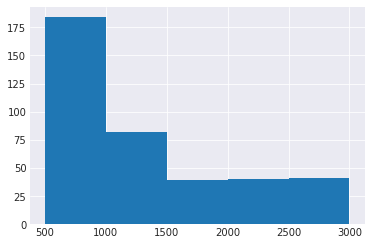

In [54]:
if FLAGS.run_analysis:
    hist_start = 500
    hist_end = 3000
    binwidth = 500
    exp_data.long_answer_len.hist(bins=range(hist_start, hist_end + binwidth, binwidth))

In [55]:
if FLAGS.run_analysis:
    exp_data['long_answer_long'] = exp_data.long_answer_len > 1000
    print('Percent of long answers > 1000 tokens: ~{}%'.format(exp_data.long_answer_long.mean()*100))

Percent of long answers > 1000 tokens: ~3.17%


3.17% is non_trivial and in line with what I'm seeing in the csv file. Thus, this doesn't represent a problem.

Now checking the submission percentages of rows without a long answer and percent of rows with a long answer that are missing a short answer. 

In [56]:
if FLAGS.run_analysis:
    print('Percent of long rows with no answer: {}%'.format(
        round(np.mean([test_answers['long_answer'] == ''])*100,2)
    ))

Percent of long rows with no answer: 41.04%


41% on a small sample size is not unreasonable compared to 50%

In [57]:
if FLAGS.run_analysis:
    has_long_mask = np.array([test_answers['long_answer'] != ''])
    has_long_no_short_mask = has_long_mask & np.array([test_answers['short_answer'] == ''])
    print('Percent of long rows with no short answer: {}%'.format(
        round(np.sum(has_long_no_short_mask)/np.sum(has_long_mask)*100,2)
    ))

Percent of long rows with no short answer: 45.1%


45.1% is reasonably higher than 28%. Enough to warrant some further investigation. To do so we'll need to run this model on a larger evaluation set. 

In [58]:
def sanity_check(answers_df):
    
    print('Percent of long rows with no answer: {}%'.format(
        round(np.mean([answers_df['long_answer'] == ''])*100,2)
    ))  
    
    has_long_mask = np.array([answers_df['long_answer'] != ''])
    has_long_no_short_mask = has_long_mask & np.array([answers_df['short_answer'] == ''])
    print('Percent of long rows with no short answer: {}%'.format(
        round(np.sum(has_long_no_short_mask)/np.sum(has_long_mask)*100,2)
    ))

I ran the model on a larger dataset (~7k) on a Google cloud GPU. Here I am loading the results for post-processing and analysis.

In [64]:
eval_arrays = np.load('bert-joint-baseline-output.npz')
results = list()
results.append(eval_arrays['unique_ids'])
results.append(eval_arrays['start_logits'])
results.append(eval_arrays['end_logits'])
results.append(eval_arrays['answer_type_logits'])

In [65]:
if FLAGS.run_valid: 
    predictions_json = gen_predictions_json(results, 
                                            FLAGS.validation_file, 
                                            FLAGS.validation_prediction_output_file, 
                                            valid_tmds)

setting up candidates file
Reading examples from: ../tf-question-answering/nqdir/simplified-nq-dev.jsonl
setting up eval features
compute_pred_dict
merging examples...
Computing predictions...


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



writing json
done


Google provides an evaluation script that also tells me the best threshold for the long and short answer scores (which is how the values were set above). This is the output of that script on the validation data.

{"long-best-threshold-f1": 0.6284669308137762, "long-best-threshold-precision": 0.5908309455587393, "long-best-threshold-recall": 0.6712239583333334, "long-best-threshold": 7.505920868068939, "long-recall-at-precision>=0.5": 0.7209201388888888, "long-precision-at-precision>=0.5": 0.5242228183683131, "long-recall-at-precision>=0.75": 0.2552083333333333, "long-precision-at-precision>=0.75": 0.7519181585677749, "long-recall-at-precision>=0.9": 0.010199652777777778, "long-precision-at-precision>=0.9": 0.9038461538461539, "short-best-threshold-f1": 0.5324295177938684, "short-best-threshold-precision": 0.5693574958813838, "short-best-threshold-recall": 0.5, "short-best-threshold": 6.110738697987074, "short-recall-at-precision>=0.5": 0.5405092592592593, "short-precision-at-precision>=0.5": 0.5, "short-recall-at-precision>=0.75": 0.31626157407407407, "short-precision-at-precision>=0.75": 0.7506868131868132, "short-recall-at-precision>=0.9": 0.11631944444444445, "short-precision-at-precision>=0.9": 0.9013452914798207}

In [66]:
if FLAGS.run_valid: 
    validation_answers = predictions_to_df(FLAGS.validation_prediction_output_file)
    sanity_check(validation_answers)

Percent of long rows with no answer: 33.14%
Percent of long rows with no short answer: 41.97%


33.14% is quite a bit higher than 50% which is what we would expect if we were going for accuracy. Perhaps a higher prediction rate increases the recall score so that's the reason for the discrepancy. 42% of long rows with no short answer is pretty close to the actual rate of 28%.

## 6. Final Submission and Analysis
I ran out of time to do more improvements i.e. training another BERT model such as RoBERTa or AlBERT, and applying any ensemble techniques. Thus, I've submitted this baseline model, which received a .61 F1 score on the private dataset. This was good enough for a ranking of 152/1240, putting me at the 12th percentile. Pretty good for my first competition and under time constraint. 

Next time it seems like it would be wise to: split up my work into separate notebooks: exploratory analysis, application of baseline model, post processing on results, training new models. In particular I think this would help me setup a more sophisticated testing harness than what I had which was pretty manual. 

What I did well was to be disciplined in terms of not trying to reinvent the wheel. I spent time understanding the data and then trying to replicate the best baseline results. I think this gave me the best bang for my buck in terms of both time to getting good results, and understanding of the problem and solutions. 